# Project Title: Passengers Count (Hourly Predictions)

Project Goal and Description: The aim of this project is to predict new passengers overtime using TLC Trip Record Data
Source Link: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf

# Import Modules

In [1]:
import os
import sys
import warnings
from credentials import *
sys.path.append(sys_path_ds)
import IPython
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from Queries.ml import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sqlalchemy import text, create_engine

# Options and Settings

In [2]:
warnings.simplefilter('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Load Image

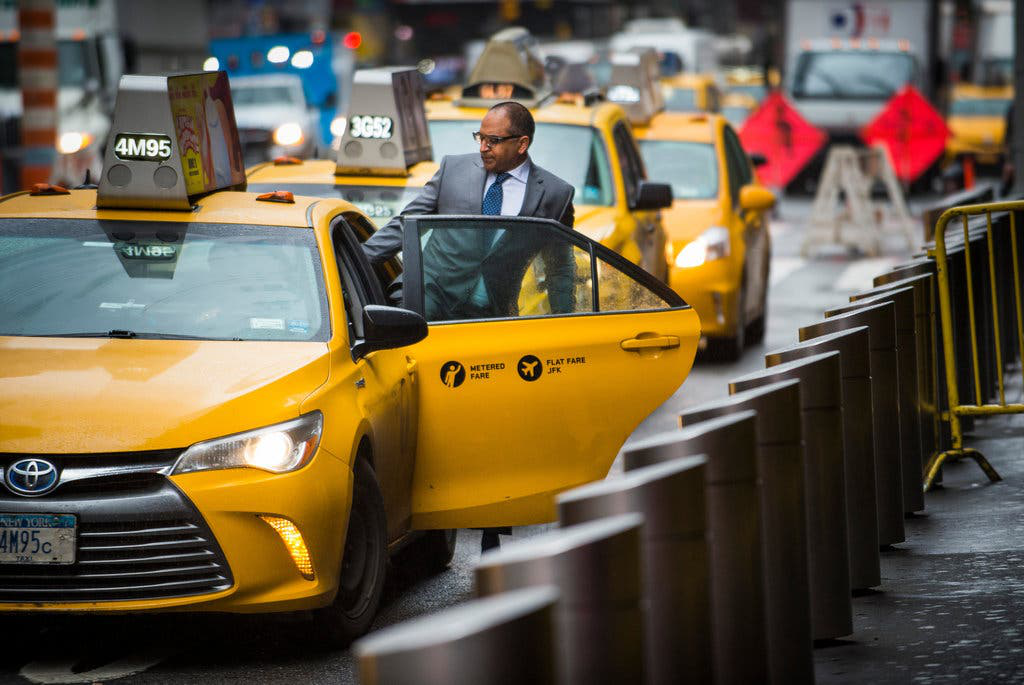

In [3]:
image_url = 'https://static01.nyt.com/images/2017/06/07/nyregion/07TAXI1/07TAXI1-jumbo.jpg?quality=75&auto=webp'
Image.open(urlopen(image_url))

# Helper Functions

In [4]:
def get_data(query: str)->pd.DataFrame:
    '''
    Fetches data from Postgresql database and returns a pandas dataframe

    '''
    engine = create_engine(f'{driver_postgres}://{user_postgres}:{password_postgres}@{hostname_postgres}/{pg_db_yt}')
    
    with engine.connect() as conn:
        df = pd.read_sql(sql=text(query), con=conn)
        conn.close()
    return df



def plot_line(data: pd.DataFrame, date: str,  rule: str, rot: int = 45, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs):
    '''
    Plots a line chart of passenger count overtime

    data: pd.DataFrame
        pandas dataframe

    date: pd.Timestamp
        date column to set as index
    
    rule: ruleDateOffset, Timedelta or str
        https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
    
    '''
    return data.set_index(date).resample(rule).count().plot(xlabel=xlabel, ylabel=ylabel, title=title, rot=rot, **kwargs)



def plot_violin(data: pd.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs):
    '''
    Draw a combination of boxplot and kernel density estimate.

    data: DataFrame, array, or list of arrays, optional
        Dataset for plotting.

    t: str
       Main plot title
    
    '''
    fig, ax = plt.subplots()
    fig.suptitle(t=t)

    sns.violinplot(data=data, **kwargs)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

    return plot_violin



def split_dataset(data, train: float = 0.8, test = None, **kwargs) -> tuple:
    '''
    Split a dataset into a left half and a right half (e.g. train / test).

    Args:
      data: A tf.data.Dataset object, or a list/tuple of arrays with the same length.

      train: it signifies the fraction of the data to pack in the left dataset. (Train Set)

      test. it signifies the fraction of the data to pack in the right dataset. (Test Set)

      Returns:
        A tuple of two tf.data.Dataset objects: the left and right splits

        https://www.tensorflow.org/api_docs/python/tf/keras/utils/split_dataset

    '''
    
    left_ds, right_ds = tf.keras.utils.split_dataset(dataset=np.array(data), left_size=train, right_size=test, **kwargs)

    print(f'Train Length: {int(left_ds.cardinality())}')
    print(f'Test Length: {int(right_ds.cardinality())}')

    train_data = list(left_ds.as_numpy_iterator())
    train_data = [train_data[i][1:] for i in range(len(train_data))]

    train_labels = list(left_ds.as_numpy_iterator())
    train_labels = pd.Series([train_labels[i][0] for i in range(len(train_labels))])

    test_data = list(right_ds.as_numpy_iterator())
    test_data = [test_data[i][1:] for i in range(len(test_data))]

    test_labels = list(right_ds.as_numpy_iterator())
    test_labels = pd.Series([test_labels[i][0] for i in range(len(test_labels))])

    return train_data, train_labels, test_data, test_labels



def normalize(data, feat_cols: list[str], axis: int = -1, order: int = 2):
    '''
    Normalizes a Numpy array.

    Args:
        data: Numpy array to normalize.
        feat_cols: Feature columns to normalize
        axis: axis along which to normalize.
        order: Normalization order (e.g. order=2 for L2 norm).

    Returns:
        A normalized copy of the array.
        
    '''
    feature_cols = data[feat_cols].columns
    features = data[feature_cols]

    return tf.keras.utils.normalize(features, axis=axis, order=order)



def window_dataset(features, targets, sequence_length: int = 1, sampling_rate: int = 1, **kwargs) -> np.array:
    '''
    Creates a dataset of sliding windows over a timeseries provided as array.

    Args:
     features: Numpy array or eager tensor

     targets: Targets corresponding to timesteps in features

     sequence_length: Length of the output sequences (in number of timesteps).

     sampling_rate: Period between successive individual timesteps

     https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

    '''
    dataset = keras.utils.timeseries_dataset_from_array(
                                                         data=features,
                                                         targets=targets,
                                                         sequence_length=sequence_length,
                                                         sampling_rate=sampling_rate,
                                                         **kwargs
                                                       )
    
    for samples, targets in dataset:
      print('samples shape:', samples.shape)
      print('targets shape:', targets.shape)
      break

    return np.float32(samples), np.float32(targets)



def model_pipeline(layers, optimizer, loss, metrics, x, y, validation_data, model_name, epochs: int = 10,  **kwargs):
  '''
  Pipeline for building, compiling and model fitting
    
  Args:
    layers: Optional list of layers to add to the model.
      optimizer: String (name of optimizer) or optimizer instance. See
      tf.keras.optimizers.
    loss: Loss function. May be a string (name of loss function), or
      a tf.keras.losses.Loss instance. See tf.keras.losses.
    metrics: List of metrics to be evaluated by the model during training and testing.
    x: Input data. 
    y: Output data.
    validation_data: data to evaluate trained model on
    model_name: name of the best saved model
    epochs: Number of epochs to train the model.
    use_multiprocessing: If True, use process-based threadin  	g.     

    Returns:
      A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, 
      as well as validation loss values and validation metrics values 
        
    '''
  model = keras.Sequential(layers=layers, **kwargs)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)
  history = model.fit(x=x, y=y, validation_data=validation_data, epochs=epochs, callbacks=[keras.callbacks.ModelCheckpoint(f'{model_name}', 
                        save_best_only=True)], use_multiprocessing=True)
    
  return pd.DataFrame(history.history)

# Extract Data

In [5]:
df = get_data(query1)
df = df.set_index('tpep_pickup_datetime').resample('H').count().reset_index()   # sample the data to one-hour intervals

In [6]:
df.head()

,tpep_pickup_datetime,passenger_count
0,2008-12-31 23:00:00,6
1,2009-01-01 00:00:00,1
2,2009-01-01 01:00:00,0
3,2009-01-01 02:00:00,0
4,2009-01-01 03:00:00,0


In [7]:
df.tail()

,tpep_pickup_datetime,passenger_count
124282,2023-03-07 09:00:00,0
124283,2023-03-07 10:00:00,0
124284,2023-03-07 11:00:00,0
124285,2023-03-07 12:00:00,0
124286,2023-03-07 13:00:00,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124287 entries, 0 to 124286
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   tpep_pickup_datetime  124287 non-null  datetime64[ns]
 1   passenger_count       124287 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 MB


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,124287.0,31.791032,330.820401,0.0,0.0,0.0,0.0,4865.0


<Axes: title={'center': 'Yearly Passenger Count OverTime'}, xlabel='Year', ylabel='Passenger Count'>

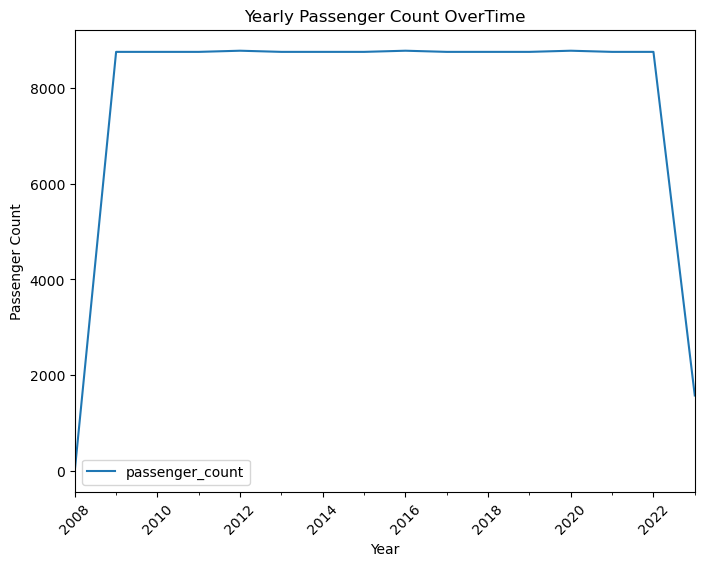

In [10]:
plot_line(df, date='tpep_pickup_datetime', rule='Y', xlabel='Year', ylabel='Passenger Count', title='Yearly Passenger Count OverTime')

<Axes: title={'center': 'Quarterly Passenger Count OverTime'}, xlabel='Year', ylabel='Passenger Count'>

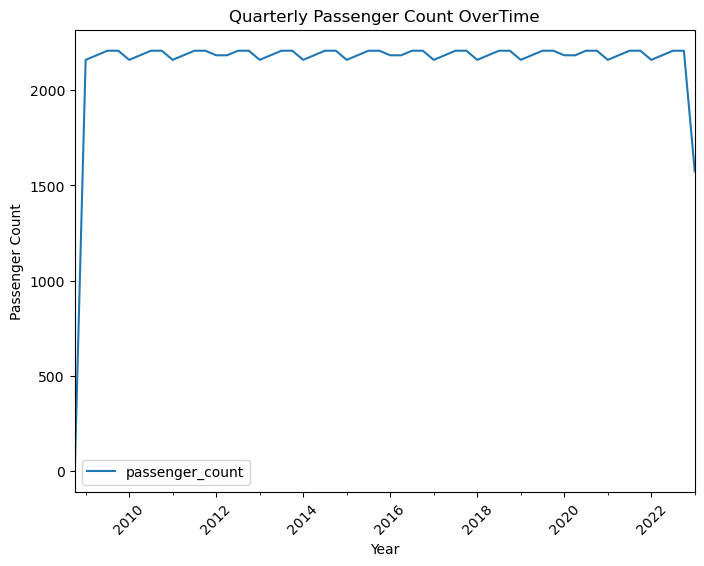

In [11]:
plot_line(df, date='tpep_pickup_datetime', rule='Q', xlabel='Year', ylabel='Passenger Count', title='Quarterly Passenger Count OverTime')

<Axes: title={'center': 'Monthly Passenger Count OverTime'}, xlabel='Year', ylabel='Passenger_count'>

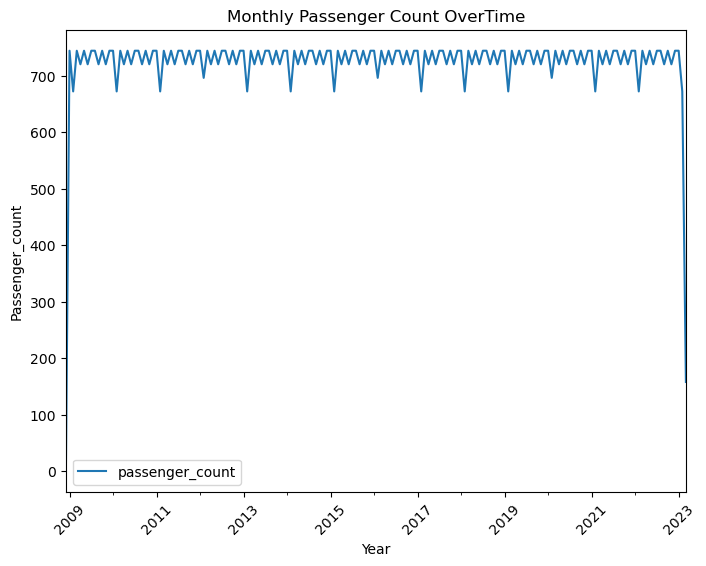

In [12]:
plot_line(df, date='tpep_pickup_datetime', rule='M', xlabel='Year', ylabel='Passenger_count', title='Monthly Passenger Count OverTime')

# Feature Engineering

Transform Timestamp Data

In [13]:
# convert the date and time when the meter was engaged to seconds
timestamp_s = df['tpep_pickup_datetime'].map(pd.Timestamp.timestamp)

# for subsequent stages of transformation, since taxi data deals with seasonality, it clearly has daily and yearly periodicity.
days_in_yr = 365.2425
hrs_in_day = 24
mins_in_hr = 60
secs_in_mins = 60 

# calculate total seconds within a day and year
secs_in_day = hrs_in_day * mins_in_hr * secs_in_mins
secs_in_yr = np.multiply(days_in_yr, secs_in_day)


df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / secs_in_day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / secs_in_day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / secs_in_yr))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / secs_in_yr))

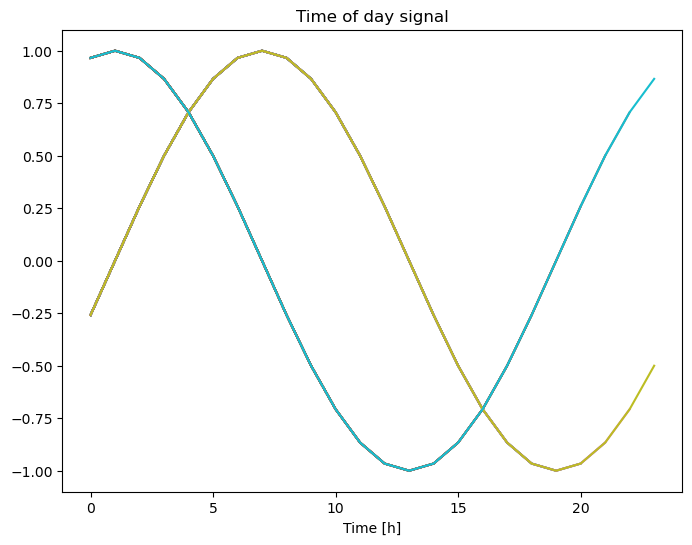

In [14]:
fig, ax = plt.subplots()

for _ in range(25):
    plt.plot(np.array(df['Day sin'])[:_])
    plt.plot(np.array(df['Day cos'])[:_])
    ax.set(title='Time of day signal', xlabel='Time [h]')

# Split Data

In [15]:
# training, validation, and test sets will comprise of (70%, 20%, 10%) of the entire data.
# randomly shuffling the data before splitting is not implemented in this case for two reasons
# - It ensures that slicing the data into windows of consecutive samples is still possible.
# - It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

num_features = df.shape[1]

column_indices = [{idx: colname} for idx, colname in enumerate(df.columns)]

n = len(df)

train_df = df[:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

print(f'Train Set: {train_df.shape},\
        Validation Set: {val_df.shape},\
        Test Set: {test_df.shape},\
        Number of Features: {num_features}'
     )

Train Set: (87000, 6),        Validation Set: (24858, 6),        Test Set: (12429, 6),        Number of Features: 6


# Data Normalization

In [16]:
feature_cols = df.drop(['tpep_pickup_datetime', 'passenger_count'], axis=1).columns
target_cols = train_df['passenger_count'].name

y_train = train_df.pop(target_cols)
y_val = val_df.pop(target_cols)
y_test = test_df.pop(target_cols)

X_train = normalize(train_df, feat_cols=feature_cols)
X_val = normalize(val_df, feat_cols=feature_cols)
X_test = normalize(test_df, feat_cols=feature_cols)

<function __main__.plot_violin(data: pandas.core.frame.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs)>

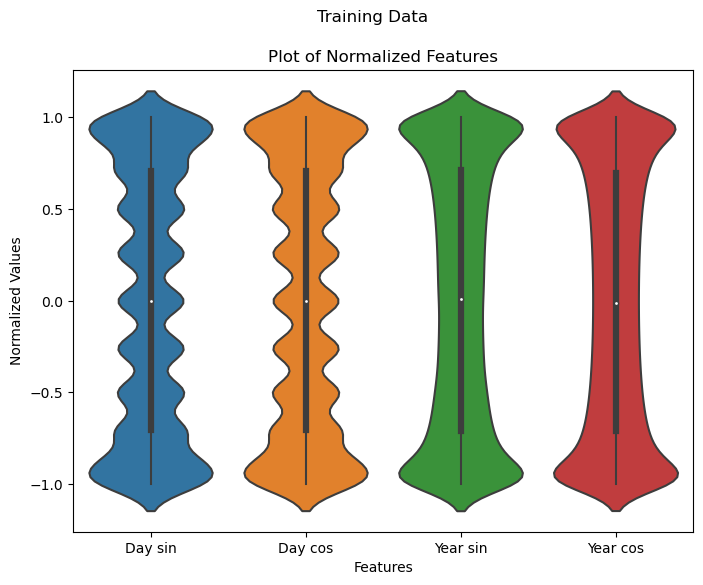

In [17]:
plot_violin(train_df, 'Training Data', 'Features', 'Normalized Values', 'Plot of Normalized Features')

<function __main__.plot_violin(data: pandas.core.frame.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs)>

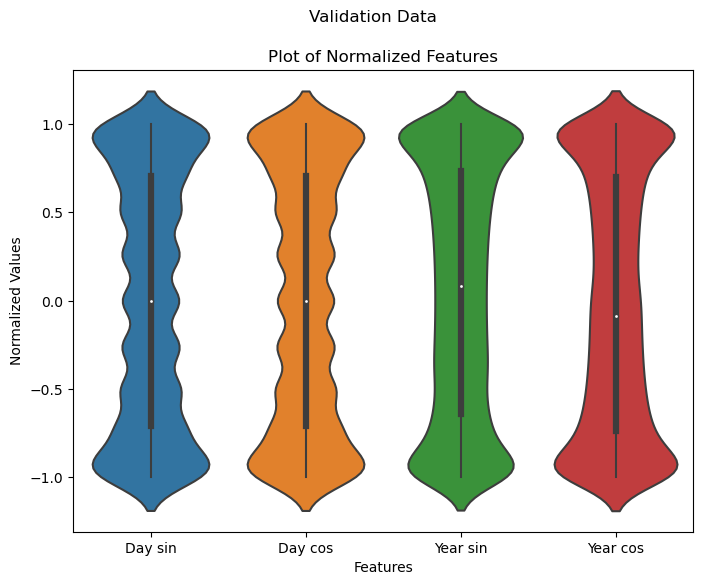

In [18]:
plot_violin(val_df, 'Validation Data', 'Features', 'Normalized Values', 'Plot of Normalized Features')

<function __main__.plot_violin(data: pandas.core.frame.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs)>

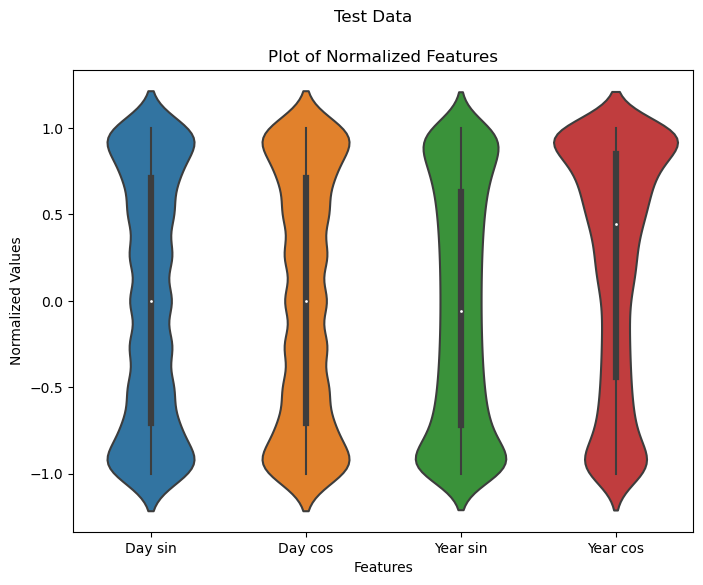

In [19]:
plot_violin(test_df, 'Test Data', 'Features', 'Normalized Values', 'Plot of Normalized Features')